<h1>EuroSAT Land Use Classification Using a
CNN–ResNet50 Hybrid Model</h1>

In [ ]:
# pip install torch torchvision torchaudio numpy matplotlib seaborn scikit-learn

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import random


In [ ]:
# -----------------------
# 1. Hyperparameters
# -----------------------
batch_size = 32
learning_rate = 0.001
num_epochs = 100
num_classes = 10

In [ ]:
# -----------------------
# 2. Transformations for Visualization
# -----------------------
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
# -----------------------
# 3. Load Dataset
# -----------------------
dataset = datasets.EuroSAT(root='./data', download=True, transform=transform)
class_names = dataset.classes

100%|██████████| 94.3M/94.3M [00:00<00:00, 201MB/s]


Total images: 27000
Number of classes: 10
Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

Class distribution:
AnnualCrop: 3000 images
Forest: 3000 images
HerbaceousVegetation: 3000 images
Highway: 2500 images
Industrial: 2500 images
Pasture: 2000 images
PermanentCrop: 2500 images
Residential: 3000 images
River: 2500 images
SeaLake: 3000 images


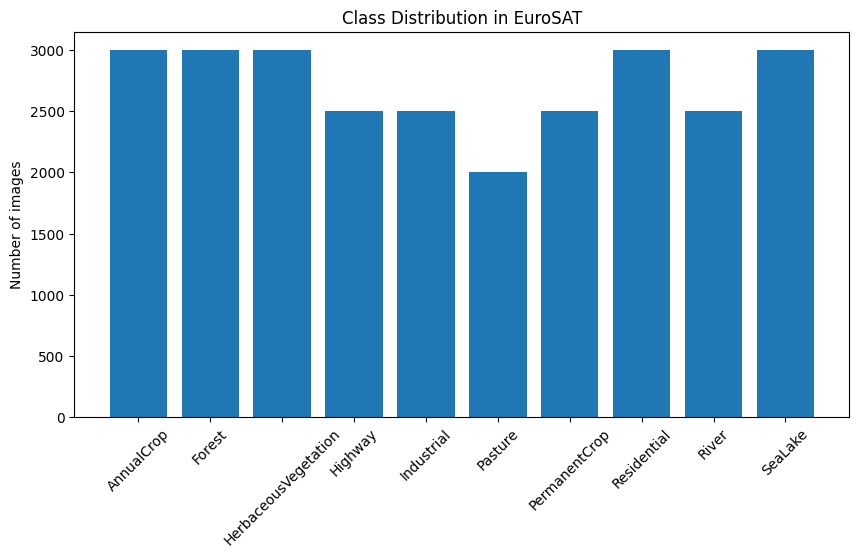

In [ ]:
# -----------------------
# 4. Dataset Overview
# -----------------------
num_images = len(dataset)
num_classes = len(dataset.classes)
class_names = dataset.classes
print(f"Total images: {num_images}")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Count images per class
labels = [label for _, label in dataset]
class_counts = Counter(labels)
print("\nClass distribution:")
for i, count in enumerate(class_counts.values()):
    print(f"{dataset.classes[i]}: {count} images")

# Plot class distribution
plt.figure(figsize=(10,5))
plt.bar([dataset.classes[i] for i in class_counts.keys()], class_counts.values())
plt.xticks(rotation=45)
plt.ylabel("Number of images")
plt.title("Class Distribution in EuroSAT")
plt.show()

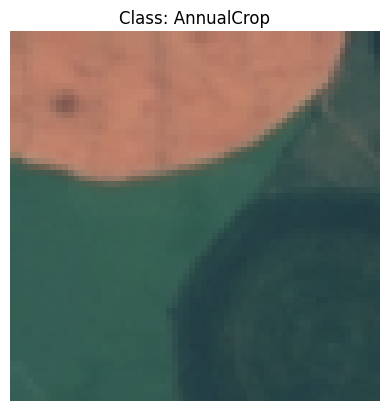

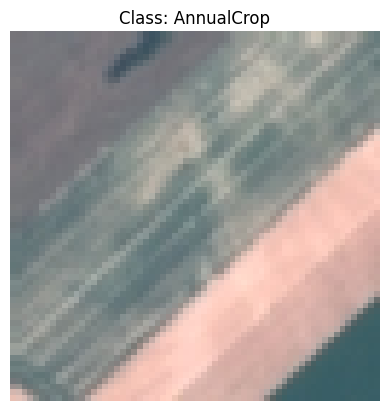

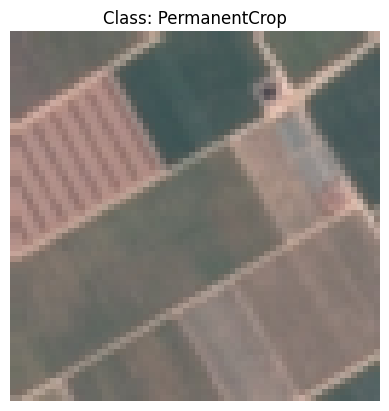

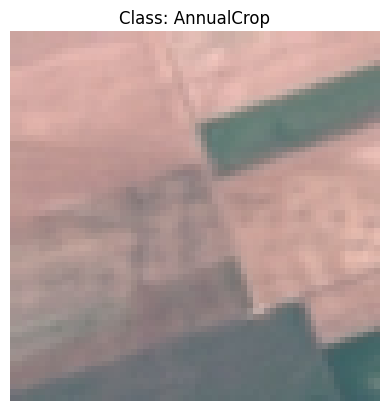

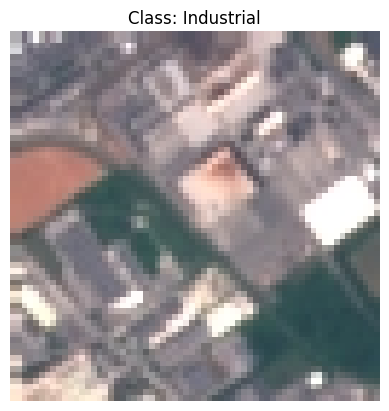

In [ ]:
# -----------------------
# 5. Sample images
# -----------------------
def imshow(img, label):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"Class: {dataset.classes[label]}")
    plt.axis('off')
    plt.show()

for _ in range(5):
    idx = random.randint(0, len(dataset)-1)
    image, label = dataset[idx]
    imshow(image, label)

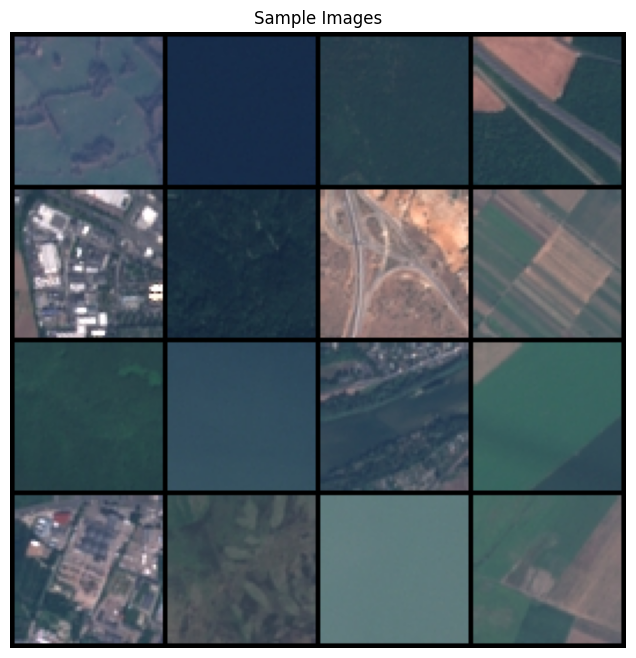

In [ ]:
# -----------------------
# 5. Grid of images
# -----------------------
def show_grid(dataset, n_images=16):
    indices = random.sample(range(len(dataset)), n_images)
    images, labels = zip(*[dataset[i] for i in indices])
    images = torch.stack(images)
    grid_img = make_grid(images, nrow=4)
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(grid_img.numpy(), (1, 2, 0)))
    plt.title("Sample Images")
    plt.axis('off')
    plt.show()

show_grid(dataset)

In [ ]:
# -----------------------
# 6. Image statistics (mean & std)
# -----------------------
loader = DataLoader(dataset, batch_size=100, shuffle=False, num_workers=0)

mean = 0.0
std = 0.0
for images, _ in loader:
    mean += images.mean([0,2,3])
    std += images.std([0,2,3])

mean /= len(loader)
std /= len(loader)
print(f"Dataset mean: {mean}")
print(f"Dataset std: {std}")

Dataset mean: tensor([0.3444, 0.3803, 0.4078])
Dataset std: tensor([0.1486, 0.1073, 0.0918])


In [ ]:
# -----------------------
# 7. Image size check
# -----------------------
sample_img, _ = dataset[0]
print(f"Sample image shape: {sample_img.shape}")  # Should be [C,H,W]

Sample image shape: torch.Size([3, 64, 64])


In [ ]:
# -----------------------
# 8. Train Test Split
# -----------------------
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# -----------------------
# 9. Define CNN + ResNet-50 Hybrid Model
# -----------------------
import torch
import torch.nn as nn
from torchvision import models

class CNN_ResNet50(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(CNN_ResNet50, self).__init__()

        self.pre_cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.channel_adapter = nn.Conv2d(128, 64, kernel_size=1)

        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
        self.resnet_features = nn.Sequential(*list(resnet.children())[4:-1])  # layers2-4


        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.pre_cnn(x)
        x = self.channel_adapter(x)
        x = self.resnet_features(x)
        x = self.fc(x)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN_ResNet50(num_classes=num_classes, pretrained=True).to(device)

print(f"Model initialized on: {device}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]


Model initialized on: cuda


In [ ]:
# -----------------------
# 10. Loss & Optimizer
# -----------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# -----------------------
# 11. Training Loop with Metrics Logging
# -----------------------
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

Epoch [1/100], Loss: 1.2924, Accuracy: 56.66%
Epoch [2/100], Loss: 0.8576, Accuracy: 71.60%
Epoch [3/100], Loss: 0.6910, Accuracy: 77.58%
Epoch [4/100], Loss: 0.5647, Accuracy: 82.08%
Epoch [5/100], Loss: 0.5106, Accuracy: 83.80%
Epoch [6/100], Loss: 0.4321, Accuracy: 86.57%
Epoch [7/100], Loss: 0.3788, Accuracy: 87.94%
Epoch [8/100], Loss: 0.3522, Accuracy: 88.76%
Epoch [9/100], Loss: 0.3292, Accuracy: 89.81%
Epoch [10/100], Loss: 0.2897, Accuracy: 91.05%
Epoch [11/100], Loss: 0.2714, Accuracy: 91.37%
Epoch [12/100], Loss: 0.2337, Accuracy: 92.44%
Epoch [13/100], Loss: 0.2234, Accuracy: 92.94%
Epoch [14/100], Loss: 0.2056, Accuracy: 93.56%
Epoch [15/100], Loss: 0.1802, Accuracy: 94.31%
Epoch [16/100], Loss: 0.2542, Accuracy: 92.29%
Epoch [17/100], Loss: 0.1637, Accuracy: 94.75%
Epoch [18/100], Loss: 0.1477, Accuracy: 95.40%
Epoch [19/100], Loss: 0.1680, Accuracy: 95.09%
Epoch [20/100], Loss: 0.1762, Accuracy: 94.69%
Epoch [21/100], Loss: 0.1091, Accuracy: 96.73%
Epoch [22/100], Loss: 

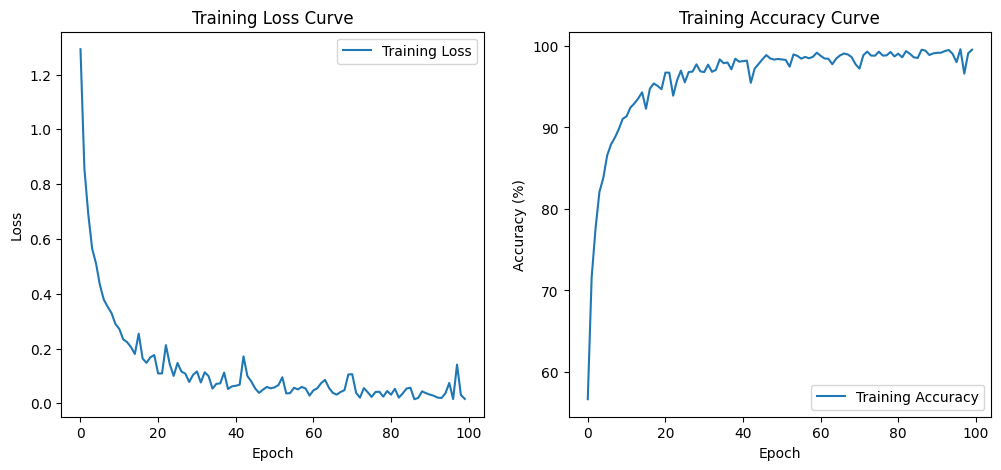

In [ ]:
# -----------------------
# 12. Plot Training Curves
# -----------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Curve')
plt.legend()
plt.show()

In [ ]:
# -----------------------
# 13. Evaluation on Test Set
# -----------------------
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"\n✅ Test Accuracy: {test_accuracy:.2f}%")


✅ Test Accuracy: 89.02%


In [ ]:
# -----------------------
# 14. Classification Report
# -----------------------
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.82      0.94      0.88       571
              Forest       0.97      0.92      0.94       577
HerbaceousVegetation       0.90      0.73      0.81       611
             Highway       0.95      0.82      0.88       477
          Industrial       0.91      0.95      0.93       497
             Pasture       0.84      0.82      0.83       414
       PermanentCrop       0.71      0.90      0.80       535
         Residential       0.98      0.93      0.96       619
               River       0.91      0.88      0.89       477
             SeaLake       0.95      0.99      0.97       622

            accuracy                           0.89      5400
           macro avg       0.89      0.89      0.89      5400
        weighted avg       0.90      0.89      0.89      5400



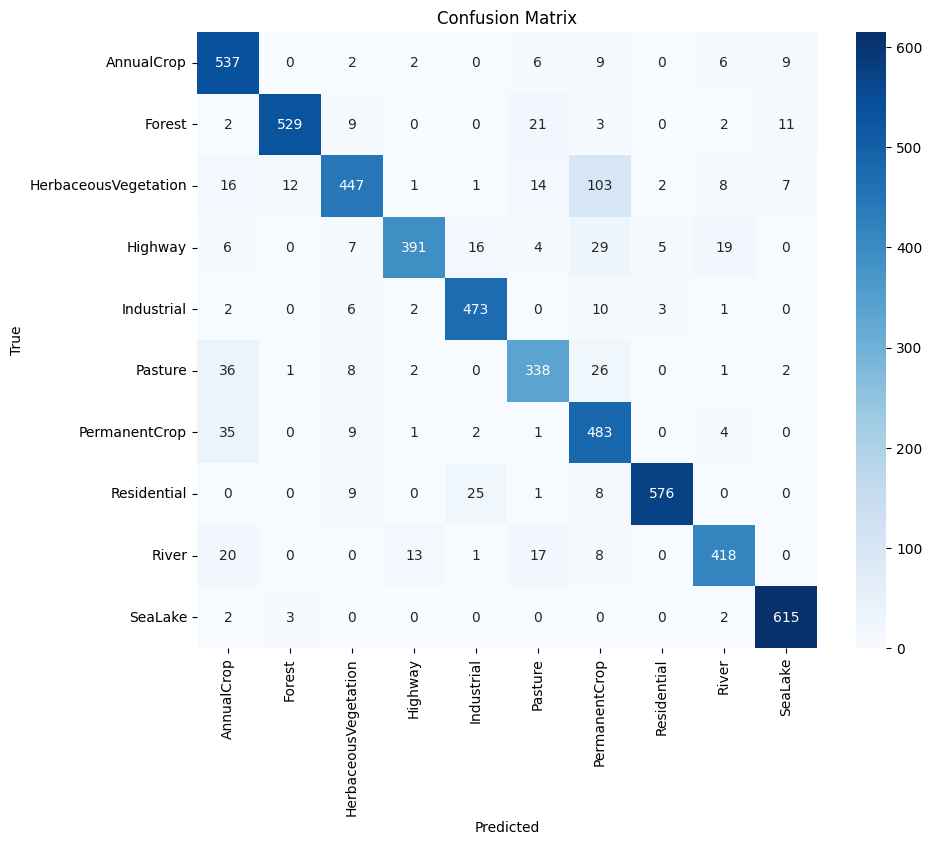

In [ ]:
# -----------------------
# 15. Confusion Matrix
# -----------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

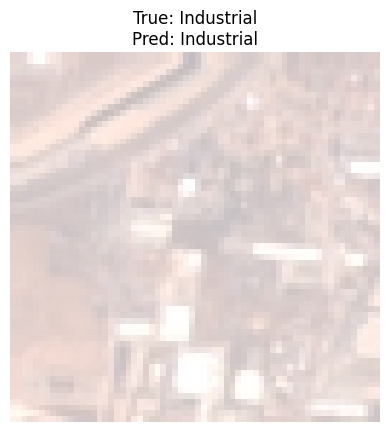

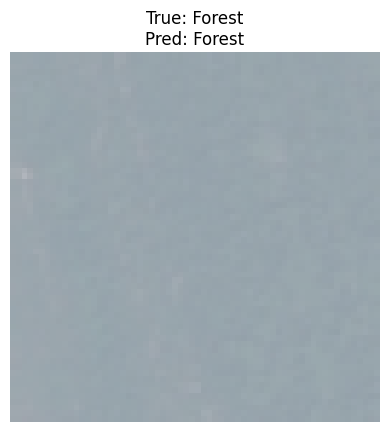

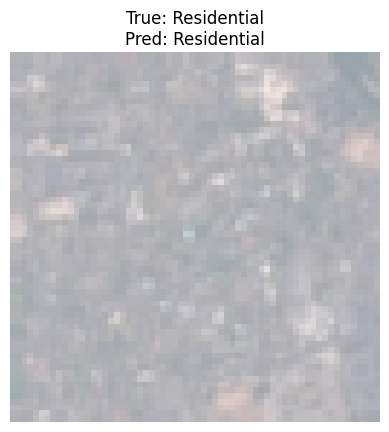

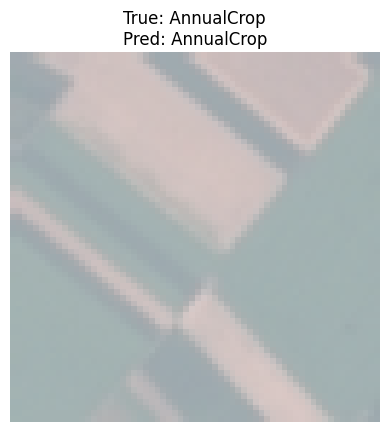

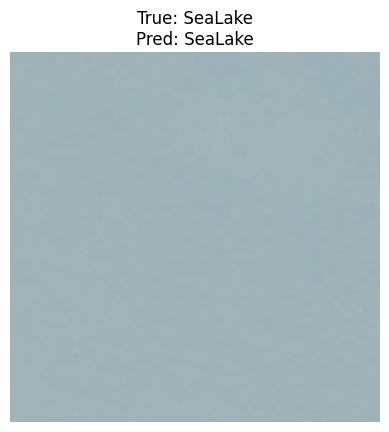

In [ ]:
# -----------------------
# 16. Visualize Some Predictions
# -----------------------
def imshow(img, label, pred):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.title(f"True: {label}\nPred: {pred}")
    plt.axis('off')
    plt.show()

# Show 5 random test images with predictions
indices = random.sample(range(len(test_dataset)), 5)
for idx in indices:
    image, label = test_dataset[idx]
    model.eval()
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        _, pred = torch.max(output, 1)
    imshow(image, class_names[label], class_names[pred.item()])